In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import vice
from scipy.optimize import curve_fit
from astropy.io import fits

In [3]:
import surp.src.analysis.rc_params
import surp.src.analysis.gas_phase_data as gap
import surp.src.analysis.plotting_utils as pluto
import surp.src.analysis.apogee_analysis as aah
from surp.src.analysis.vice_model import vice_model

In [4]:
berg19 = pd.read_csv("../../data/berg19.csv")
berg19 = berg19.iloc[:-1]
berg19["[c/o]"] = berg19.log_c_o + np.log10(12/16) - np.log10(vice.solar_z("c")/vice.solar_z("o"))
berg19["[o/h]"] = berg19.eps_o + np.log10(16) - np.log10(vice.solar_z("o")) - 12

Below this is Lya, compilation of : a1: Cooke et al. (2015); 2: Dutta et al. (2014); 3: Cooke et al. (2014);
4: Ellison et al. (2010); 5: Cooke et al. (2011b); 6: This work; 7: Pettini et al.
(2008); 8: Morrison et al. (2016); 9: Srianand et al. (2010); 10: Cooke et al.
(2012); 11: Dessauges-Zavadsky et al. (2003)

In [5]:
cooke17 = pd.read_csv("../../data/cooke17.csv")


In [6]:
RL = pd.read_csv("../../data/extragalactic_RL.csv", sep="\t+")

/apps/project/ondemand/app_jupyter/3.1.18/lib64/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [7]:
RL["[c/o]"] = aah.log_to_bracket(RL.eps_c - RL.eps_o,
                                       "c", "o")
RL["[o/h]"] = aah.log_to_bracket(RL.eps_o, "o") - 12
RL["[c/o]_err"] = RL.c_err + RL.o_err
RL["[o/h]_err"] = RL.o_err 

In [20]:
fiducial = vice_model("../../output/C11_f0.2_eta1_beta0.001.json")

In [10]:
table = fits.open("../../data/J_A+A_568_A25_table5.dat.fits")[1]
N14 = pd.DataFrame(table.data)
filt = N14["[C/H]"] != 0 
filt &= N14["[O/H]3n"] != 0
N14 = N14[filt]

In [11]:
F09 = pd.read_csv("../../data/Fabbian09.csv", sep="\s+")

Redshift: (Pettini et al. 2000;
Fosbury & Villar-Martín et al. 2003; Erb et al. 2010; Christensen
et al. 2012; Bayliss et al. 2014; James et al. 2014; Stark et al.
2014; Steidel et al. 2016; Vanzella et al. 2016; Amorín et al.
2017; Berg et al. 2018; Rigby et al. 2018)

RL: (teal squares: Esteban et al. 2002, 2009,
2014; Pilyugin & Thuan 2005; García-Rojas & Esteban 2007;
López-Sánchez et al. 2007).

CL: Senchyna et al. (2017) and Peña-Guerrero et al. (2017)

MW stars: Gustafsson et al. (1999), Akerman
et al. (2004), Fabbian et al. (2009), and Nissen et al. (2014)

In [13]:
berg19["[c/o]_err"] = berg19.log_c_o_err
berg19["[o/h]_err"] = berg19.eps_o_err
cooke17["[c/o]"] = cooke17.c_o
cooke17["[c/o]_err"] = cooke17.c_o_err
cooke17["[o/h]"] = cooke17.o_h
cooke17["[o/h]_err"] = cooke17.o_h_err

F09["[c/o]"] = F09.co
F09["[o/h]"] = F09.oh
F09["[c/o]_err"] = [0.05]*len(F09)
F09["[o/h]_err"] = [0.05]*len(F09)

N14["[c/o]"] = N14["[C/H]n"] - N14["[O/H]3n"]
N14["[o/h]"] = N14["[O/H]3n"]

N14["[c/o]_err"] = [0.05]*len(N14)
N14["[o/h]_err"] = [0.05]*len(N14)

In [15]:
all_abundances = pd.DataFrame(columns=["[c/o]", "[c/o]_err", "[o/h]", "[o/h]_err", "type"])


for df, label in [(RL, "RL"), (berg19, "dwarf"), (gap.read_skillman20(), "RL"), (gap.read_md22(), "RL"), 
                  (cooke17, "DLA"), (N14, "star"), (F09, "star")]:
    all_abundances = all_abundances.append(pd.DataFrame({
        "[c/o]": df["[c/o]"],
        "[c/o]_err": df["[c/o]_err"],
        "[o/h]": df["[o/h]"],
        "[o/h]_err": df["[o/h]_err"],
        "type": [label]*len(df)
    }), ignore_index=True)


In [21]:
subgiants = aah.subgiants
filt = ~np.isnan(subgiants["C_MG"])
filt &= ~np.isnan(subgiants["MG_H"])
filt &= subgiants["high_alpha"]
subgiants = subgiants[filt]

In [42]:
import arya
arya.style.set_size((4, 2*np.sqrt(2)))

In [43]:
import json

In [44]:
all_abundances.to_csv("all_data.csv")

In [47]:
plt.style.use("../../../arya/style/journal.mplstyle")

one file saved at ./summary.pdf


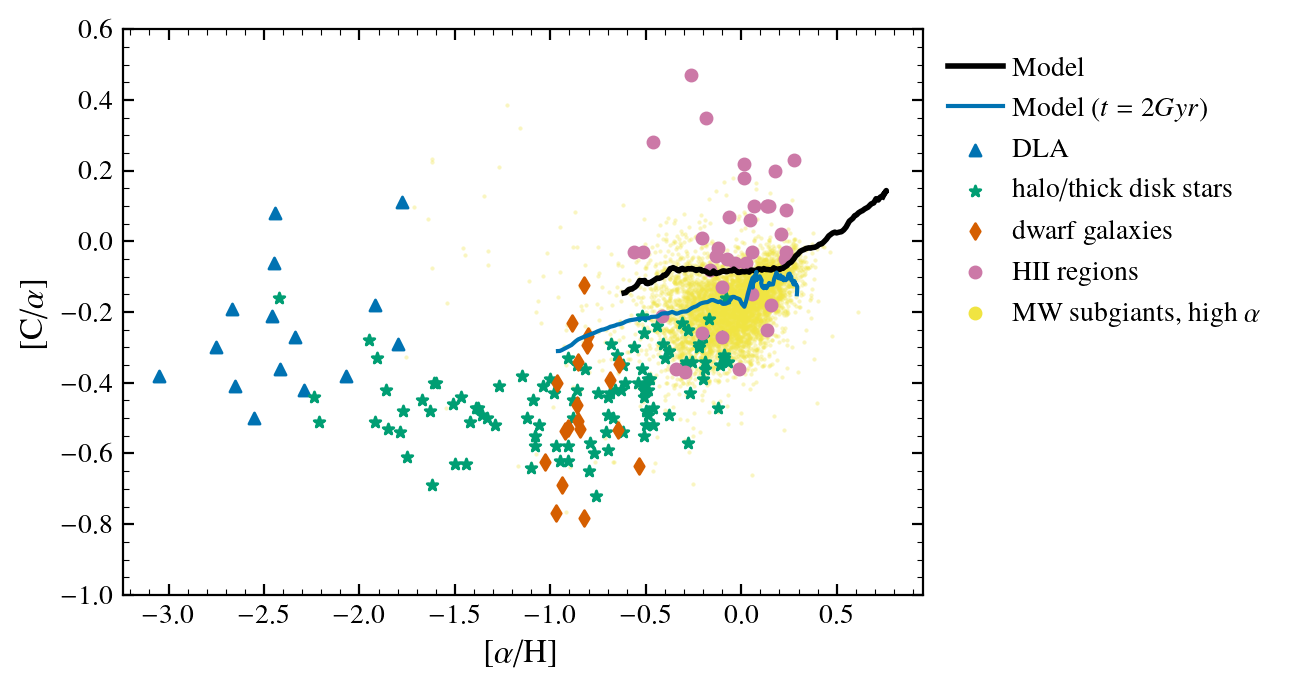

In [53]:
arya.style.set_size((4, 2*np.sqrt(2)))
sp = arya.Subplot()

for i in [3,2,1,0]:
    label = ["HII regions", "dwarf galaxies", "halo/thick disk stars", "DLA"][i]
    val = ["RL", "dwarf", "star", "DLA"][i]
    df = all_abundances[all_abundances.type == val]
    plt.scatter(df["[o/h]"], df["[c/o]"], label=label,
               marker=["o", "d", "*", "^"][i])
    
    
fiducial.plot_gas("[o/h]", "[c/o]", label="Model", plot_data=False, color="k", zorder=3, lw=2)

fiducial.plot_annulus_at_t("[o/h]", "[c/o]", t=2, label="Model $(t=2Gyr)$", zorder=3, lw=1.5)


ha = subgiants["high_alpha"]
df = subgiants[ha]
plt.scatter(df["MG_H"], df["C_MG"], s=0.3, alpha=0.3, zorder=-1, label="MW subgiants, high $\\alpha$")

plt.ylim(-1, 0.6)

plt.xlabel(r"[$\alpha$/H]")
plt.ylabel(r"[C/$\alpha$]")

leg = pluto.legend_outside()
leg.legendHandles[-1].set_sizes([16])
leg.legendHandles[-1].set_alpha(1)
sp.save("summary.pdf")

In [35]:
l = _

In [ ]:
l.set_sizes

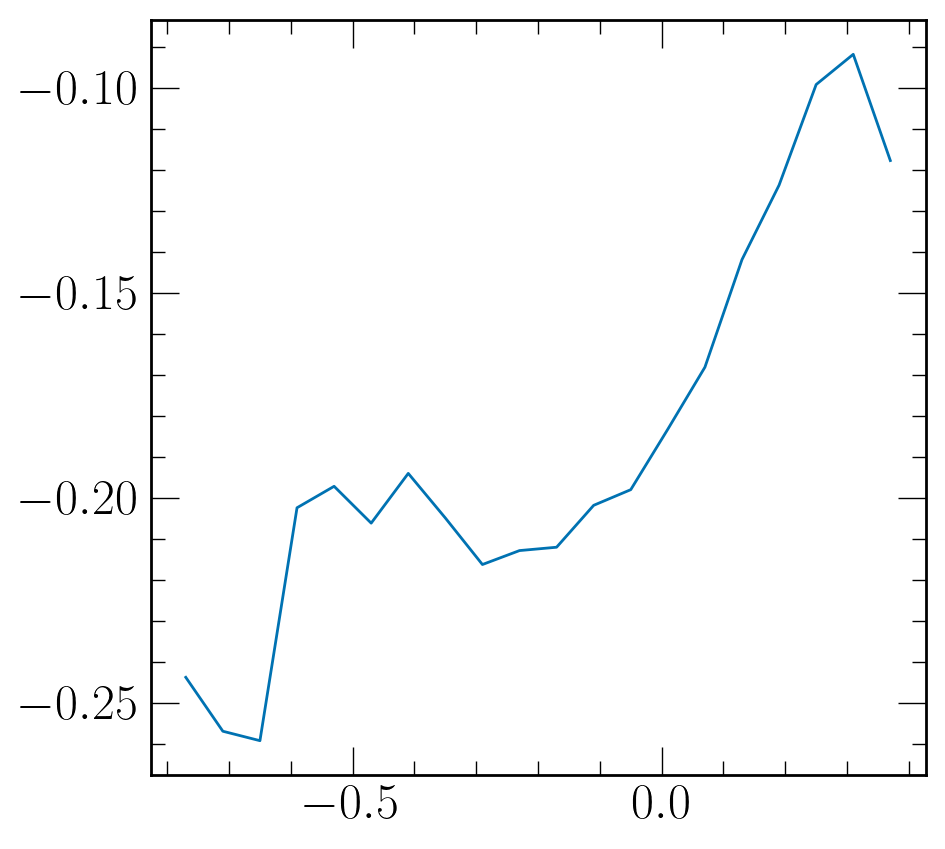

In [18]:
subgiants = aah.subgiants
filt = ~np.isnan(subgiants["C_MG"])
filt &= ~np.isnan(subgiants["MG_H"])
filt &= subgiants["high_alpha"]
df = subgiants[filt]
medians, bins, devs = pluto.plot_median_track(df["MG_H"], df["C_MG"], min_count=5, xlim=(-0.8, 1))

In [30]:
def model(x, a, b):
    return a*x + b

filt = ~np.isnan(all_abundances["[o/h]"])
filt &= ~np.isnan(all_abundances["[c/o]"])
filt &= all_abundances["[c/o]_err"] > 0
df = all_abundances[filt]
popt, covt = curve_fit(model, df["[o/h]"], df["[c/o]"], sigma=df["[c/o]_err"])

In [31]:
popt

array([ 0.03592007, -0.34787128])

In [32]:
filt = ~np.isnan(subgiants["MG_H"])
filt &= ~np.isnan(subgiants["C_MG"])
df = subgiants[filt]
popt2, covt = curve_fit(model, df["MG_H"], df["C_MG"])


In [33]:
popt

array([ 0.03592007, -0.34787128])

In [14]:
subgiants_binned = pd.DataFrame(
{
    "[o/h]": bins,
    "[o/h]_err": 0.5*(bins[1] - bins[0]),
    "[c/o]": medians,
    "[c/o]_err": devs
})

NameError: name 'bins' is not defined

In [34]:
covt.diagonal()**0.5

array([0.00309706, 0.00072805])

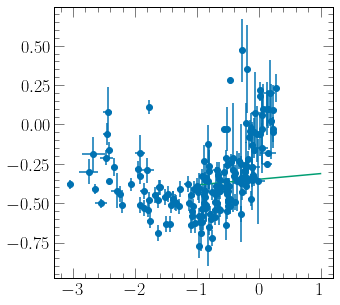

In [35]:
pluto.err_scatter(all_abundances["[o/h]"], all_abundances["[c/o]"], all_abundances["[c/o]_err"], all_abundances["[o/h]_err"])
x = np.linspace(-1, 1, 1000)
y =model(x, *popt)
plt.plot(x, y)

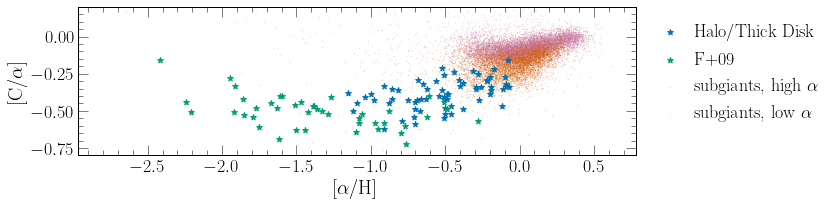

In [52]:
plt.figure(figsize=(10, 5))

plt.scatter(N14["[O/H]3n"], N14["[C/H]n"]-N14["[O/H]3n"], marker="*", label="Halo/Thick Disk")
plt.scatter(F09.oh, F09.co, label="F+09", marker="*")
# plt.scatter(subgiants["O_H"], subgiants["C_O"], s=0.1, alpha=0.1, color="k", zorder=-2)

ha = subgiants["high_alpha"]
df = subgiants[ha]
plt.scatter(df["MG_H"], df["C_MG"], s=0.1, alpha=0.3, zorder=-1, label="subgiants, high $\\alpha$")
df = subgiants[~ha]
plt.scatter(df["MG_H"], df["C_MG"], s=0.1, alpha=0.3, zorder=-2, label="subgiants, low $\\alpha$")

plt.ylim(-0.8, 0.2)
plt.xlabel(r"[$\alpha$/H]")
plt.ylabel(r"[C/$\alpha$]")
pluto.legend_outside()
plt.gca().set_aspect("equal")
sf("high_alpha_halo")

In [37]:
vice.solar_z("c")* 8e-3 /0.014 * (10**0.86 - 1) *(3-0.76)/3

0.0062876538273151025

In [38]:
0.427*1.89e-3/1 - vice.solar_z("c")

-0.0015529700000000003

In [39]:
9.116E-04/1 - vice.solar_z("c")

-0.0014484

In [40]:
0.415*2.19e-3

0.00090885

In [41]:
1.872e-03/2/12 - vice.solar_z("c")

-0.002282

In [42]:
(10**2.56) 

363.0780547701014

In [43]:
g, m, z =vice.yields.agb.grid("c", "ventura13")
for i in range(len(z)):
    print(z[i])
    for j in range(len(m)):
        print(m[j], "\t", g[j][i])


0.0003
1.5 	 0.00322147
2.0 	 0.0125005
2.5 	 0.00347671
3.0 	 0.000222133
3.5 	 0.000166
4.0 	 8.77e-05
4.5 	 6.33778e-05
5.0 	 1.806e-05
6.0 	 -1.31167e-05
6.5 	 -1.42385e-05
7.0 	 -1.26714e-05
0.001
1.5 	 0.00644115
2.0 	 0.0098009
2.5 	 0.00896015
3.0 	 0.00109967
3.5 	 0.000105029
4.0 	 3.06e-05
4.5 	 -1.45778e-05
5.0 	 -4.39e-05
6.0 	 -5.32333e-05
6.5 	 -5.33231e-05
7.0 	 -5.23714e-05
0.002
1.5 	 0.00356587
2.0 	 0.00765194
2.5 	 0.00688204
3.0 	 0.000855667
3.5 	 2.63429e-05
4.0 	 -3.4575e-05
4.5 	 -7.82667e-05
5.0 	 -9.56e-05
6.0 	 -0.000105367
6.5 	 -0.000113923
7.0 	 -0.000113843
0.004
1.5 	 0.00388673
2.0 	 0.0130065
2.5 	 0.0102057
3.0 	 0.00610026
3.5 	 0.000133714
4.0 	 -2.05e-05
4.5 	 -0.000113333
5.0 	 -0.0001474
6.0 	 -0.000324
6.5 	 -0.000359354
7.0 	 -0.000357471
0.008
1.5 	 0.00147993
2.0 	 0.00303011
2.5 	 0.00736051
3.0 	 0.00550038
3.5 	 -0.000192
4.0 	 -0.00046075
4.5 	 -0.000516
5.0 	 -0.0006167
6.0 	 -0.000717067
6.5 	 -0.000705846
7.0 	 -0.000731143
0.014
1.5

In [44]:
(9.1e-4*0.415 - vice.solar_z("c"))/1

-0.00198235

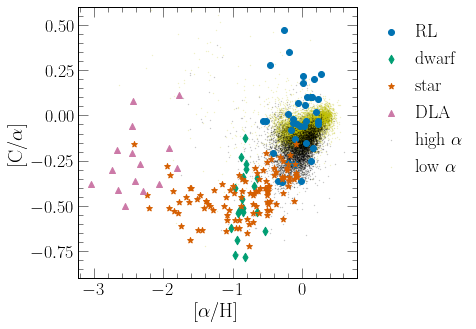

In [45]:
for i in range(4):
    val = ["RL", "dwarf", "star", "DLA"][i]
    df = all_abundances[all_abundances.type == val]
    plt.scatter(df["[o/h]"], df["[c/o]"], label=val,
               marker=["o", "d", "*", "^"][i])
    
ha = subgiants["high_alpha"]
df = subgiants[ha]
plt.scatter(df["MG_H"], df["C_MG"], s=0.1, alpha=0.3, color="k", zorder=-2, label="high $\\alpha$")

df = subgiants[~ha]
plt.scatter(df["MG_H"], df["C_MG"], s=0.1, alpha=0.3, color="y", zorder=-3, label="low $\\alpha$")

plt.ylim(-0.9, 0.6)
plt.xlabel(r"[$\alpha$/H]")
plt.ylabel(r"[C/$\alpha$]")
pluto.legend_outside()

sf("summary_high_low_a")

(<matplotlib.lines.Line2D at 0x2ae923e63c88>,
 (),
 (<matplotlib.collections.LineCollection at 0x2ae923e63128>,
  <matplotlib.collections.LineCollection at 0x2ae923ebf550>))

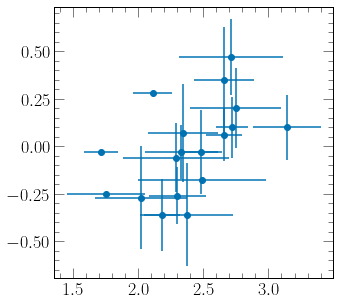

In [56]:
pluto.err_scatter(RL.eps_o - RL.eps_fe, RL["[c/o]"], RL["[c/o]_err"], RL.o_err + RL.fe_err)

In [79]:
N14.columns

Index(['Name', 'm_Name', 'Teff', 'logg', '[Fe/H]', 'vt', '[C/H]', '[C/H]n',
       '[O/H]3', '[O/H]3n', '[O/H]', 'Pop', 'Bin', '[c/o]', '[o/h]',
       '[c/o]_err', '[o/h]_err'],
      dtype='object')

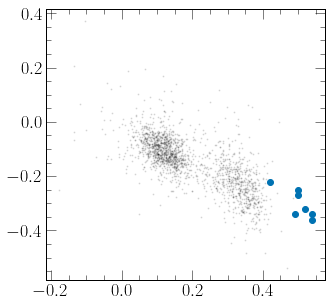

In [87]:
o_0 = -0.2

filt = N14["[O/H]3"] < 0.05 + o_0
filt &= N14["[O/H]3"] > -0.05 + o_0
df = N14[filt]

pluto.err_scatter(df["[O/H]3"] - df["[Fe/H]"], df["[c/o]"])

aah.plot_coofe(o_0)

In [88]:
aah.plot_coofe?

Signature: aah.plot_coofe(c=-0.1, w=0.05, s=1, alpha=0.1, color='black', **kwargs)
Docstring: <no docstring>
File:      ~/surp/analysis_scripts/apogee_analysis.py
Type:      function


(-0.8, 0.3)

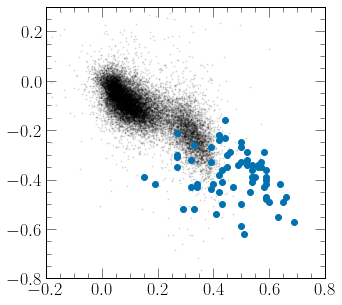

In [93]:

df = N14

pluto.err_scatter(df["[O/H]3"] - df["[Fe/H]"], df["[c/o]"])
aah.plot_coofe(w=10)
plt.xlim(-0.2, 0.8)
plt.ylim(-0.8, 0.3)

plt.xlim("[$\\alpha)

(array([ 5.,  2.,  5.,  7., 10., 13.,  5.,  6.,  8.,  4.]),
 array([-1.17 , -1.053, -0.936, -0.819, -0.702, -0.585, -0.468, -0.351,
        -0.234, -0.117,  0.   ]),
 <BarContainer object of 10 artists>)

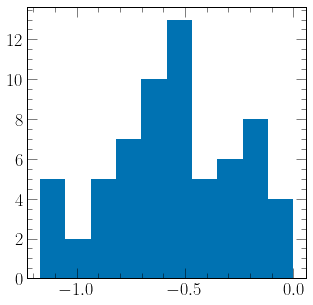

In [74]:
plt.hist(N14["[O/H]3"])

In [78]:
sum(N14["[O/H]3"] != 0)

64

/users/PAS2232/aeyobd/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(-0.5, 0.5)

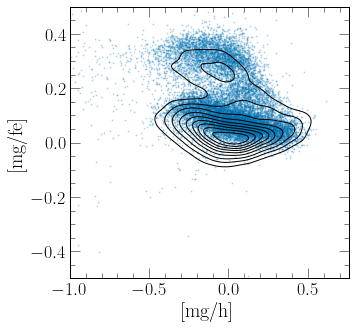

In [103]:
df = aah.subgiants

plt.scatter(df["MG_H"], df["MG_FE"], s=1, alpha=0.2)

aah.plot_v21_contour("[mg/h]", "[mg/fe]", exclude_high_alpha=False)
plt.xlim(-1)
plt.ylim(-0.5, 0.5)

In [105]:
v21 = aah.vincenzo2021()

(array([7.16147672e-04, 3.58073836e-04, 3.58073836e-04, 1.07422151e-03,
        0.00000000e+00, 2.50651685e-03, 5.01303371e-03, 5.37110754e-03,
        6.80340289e-03, 7.16147672e-03, 1.11002889e-02, 1.96940610e-02,
        2.90039807e-02, 9.59637881e-02, 5.63608218e-01, 1.32272475e+00,
        1.89242022e+00, 1.35674177e+00, 5.15268250e-01, 2.72136115e-02]),
 array([-2.79775715, -2.62719894, -2.45664073, -2.28608252, -2.11552432,
        -1.94496611, -1.7744079 , -1.60384969, -1.43329148, -1.26273327,
        -1.09217507, -0.92161686, -0.75105865, -0.58050044, -0.40994223,
        -0.23938403, -0.06882582,  0.10173239,  0.2722906 ,  0.44284881,
         0.61340702]),
 [<matplotlib.patches.Polygon at 0x2ae924041cc0>])

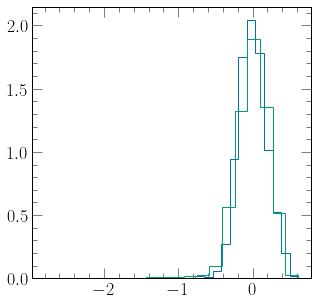

In [111]:
plt.hist(v21["[mg/h]"], histtype="step", bins=20, density=True)
plt.hist(aah.subgiants["MG_H"], histtype="step", bins=20, density=True)